# **Import Libraries**

In [ ]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from skimage.util import montage as montage2d
from skimage.io import imread
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Dataset**

In [ ]:

all_xray_df = pd.read_csv('/content/drive/MyDrive/Data_Entry_2017_v2020.csv')
all_xray_df.sample(5)
all_image_paths =  glob('/content/drive/MyDrive/Images/image*/*.png')
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

Scans found: 112120 , Total Headers 112120


In [ ]:
img_paths = {os.path.basename(x): x for x in all_image_paths}
all_xray_df['path'] = all_xray_df['Image Index'].map(img_paths.get)
all_xray_df['Pneumonia'] = all_xray_df['Finding Labels'].map(lambda x: 'Pneumonia' in x)
all_xray_df['Patient Age'] = np.clip(all_xray_df['Patient Age'], 5, 100)
all_xray_df['Patient Male'] = all_xray_df['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male
62708,00015530_030.png,Infiltration|Pneumothorax,36,15530,20,M,AP,3056,2544,0.139000,0.139000,/content/drive/MyDrive/Images/image7/00015530_...,False,1.0
84339,00020726_002.png,No Finding,0,20726,45,M,PA,2646,2662,0.143000,0.143000,/content/drive/MyDrive/Images/image9/00020726_...,False,1.0
107072,00028882_002.png,Infiltration,2,28882,29,M,PA,2021,2021,0.194311,0.194311,/content/drive/MyDrive/Images/image12/00028882...,False,1.0


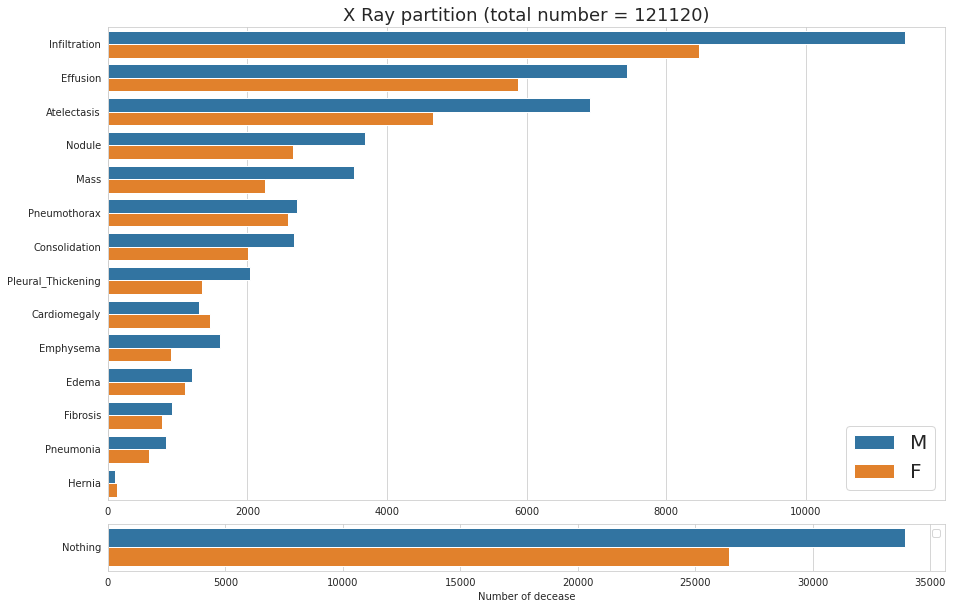

In [ ]:
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    all_xray_df[pathology] = all_xray_df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(all_xray_df,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

all_xray_df['Nothing']=all_xray_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(all_xray_df,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)
all_xray_df['Pneumonia'] = all_xray_df['Finding Labels'].map(lambda x: 'Pneumonia' in x)

## **NO FINDINGS**

1    60361
0    51759
Name: Nothing, dtype: int64


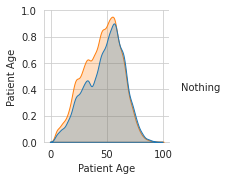

In [ ]:
positive_cases = np.sum(all_xray_df['Nothing']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Nothing']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Nothing'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Nothing']], hue='Nothing')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Nothing']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Nothing']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Nothing'].value_counts())
print('test', test_df['Nothing'].value_counts())
raw_train_df.sample(1)

train 78484 validation 20181 test 13455
train 1    42253
0    36231
Name: Nothing, dtype: int64
test 1    7244
0    6211
Name: Nothing, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
109553,00018838_002.png,No Finding,0,18838,58,F,PA,2274,2645,0.143,0.143,/content/drive/MyDrive/Images/image9/00018838_...,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# *Undersampling*

In [ ]:
train_df = raw_train_df.groupby(['Nothing']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 78484


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Nothing',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 112120 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


# **TRAIN MODEL**

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.1203 - binary_accuracy: 0.4951 - mae: 0.5024 
Epoch 00001: val_loss improved from inf to 0.69329, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 373s 36s/step - loss: 2.1203 - binary_accuracy: 0.4951 - mae: 0.5024 - val_loss: 0.6933 - val_binary_accuracy: 0.4562 - val_mae: 0.5001
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.0377 - binary_accuracy: 0.5115 - mae: 0.4922 
Epoch 00002: val_loss did not improve from 0.69329
10/10 [==============================] - 359s 36s/step - loss: 1.0377 - binary_accuracy: 0.5115 - mae: 0.4922 - val_loss: 0.6969 - val_binary_accuracy: 0.4562 - val_mae: 0.5016
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8790 - binary_accuracy: 0.5189 - mae: 0.4917 
Epoch 00003: val_loss did not improve from 0.69329
10/10 [==============================] - 355s 36s/step - loss: 0.8790 - binary_accuracy: 0.5189 - m

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 24s 349ms/step


In [ ]:
pred_Y

array([[0.47720206],
       [0.47720206],
       [0.47720206],
       ...,
       [0.47720206],
       [0.47720206],
       [0.47720206]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.47720206], dtype=float32)

# **Accuracy**

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.456197589635849


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5


# **Classification Report**

              precision    recall  f1-score   support

    Findings       0.00      0.00      0.00       979
 No Findings       0.54      1.00      0.70      1167

    accuracy                           0.54      2146
   macro avg       0.27      0.50      0.35      2146
weighted avg       0.30      0.54      0.38      2146



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


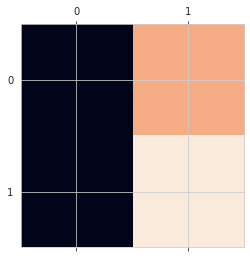

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.4500000))
print(classification_report(y_test, pred_Y>0.45550000, target_names = ['Findings', 'No Findings']))

## **Atelectasis**

0    23116
1    11559
Name: Atelectasis, dtype: int64


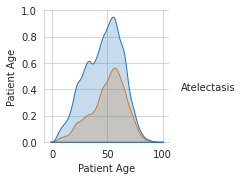

In [ ]:
positive_cases = np.sum(all_xray_df['Atelectasis']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Atelectasis']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Atelectasis'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Atelectasis']], hue='Atelectasis')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Atelectasis']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Atelectasis']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Atelectasis'].value_counts())
print('test', test_df['Atelectasis'].value_counts())
raw_train_df.sample(1)

train 24272 validation 6241 test 4162
train 0    16181
1     8091
Name: Atelectasis, dtype: int64
test 0    2775
1    1387
Name: Atelectasis, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
10224,00002714_000.png,No Finding,0,2714,66,M,PA,2500,2048,0.171,0.171,/content/drive/MyDrive/Images/image2/00002714_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# *Undersampling*

In [ ]:
train_df = raw_train_df.groupby(['Atelectasis']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 24272


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Atelectasis',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 34675 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.6456 - binary_accuracy: 0.5762 - mae: 0.4301 
Epoch 00001: val_loss improved from inf to 0.68225, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 354s 35s/step - loss: 1.6456 - binary_accuracy: 0.5762 - mae: 0.4301 - val_loss: 0.6822 - val_binary_accuracy: 0.6794 - val_mae: 0.4943
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9149 - binary_accuracy: 0.5900 - mae: 0.4427 
Epoch 00002: val_loss improved from 0.68225 to 0.67904, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 348s 35s/step - loss: 0.9149 - binary_accuracy: 0.5900 - mae: 0.4427 - val_loss: 0.6790 - val_binary_accuracy: 0.6794 - val_mae: 0.4925
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7614 - binary_accuracy: 0.6180 - mae: 0.4435 
Epoch 00003: val_loss improved from 0.67904 to 0.66613, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 25s 359ms/step


In [ ]:
pred_Y

array([[0.24988809],
       [0.24988806],
       [0.24988809],
       ...,
       [0.24988812],
       [0.24988812],
       [0.24988812]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.24988806], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.67940354347229


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.4929768000127604


                precision    recall  f1-score   support

No Atelectasis       0.68      0.10      0.17      1458
   Atelectasis       0.32      0.90      0.47       688

      accuracy                           0.36      2146
     macro avg       0.50      0.50      0.32      2146
  weighted avg       0.57      0.36      0.27      2146



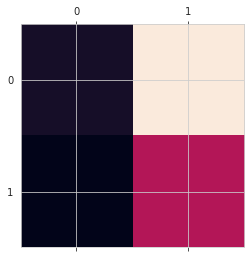

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.24988806))
print(classification_report(y_test, pred_Y>0.24988806, target_names = ['No Atelectasis', 'Atelectasis']))

## **Cardiomegaly**

0    5552
1    2776
Name: Cardiomegaly, dtype: int64


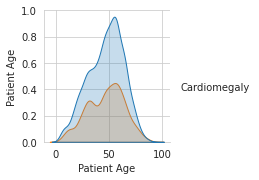

In [ ]:
positive_cases = np.sum(all_xray_df['Cardiomegaly']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Cardiomegaly']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Cardiomegaly'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Cardiomegaly']], hue='Cardiomegaly')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Cardiomegaly']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Cardiomegaly']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Cardiomegaly'].value_counts())
print('test', test_df['Cardiomegaly'].value_counts())
raw_train_df.sample(1)

train 5829 validation 1499 test 1000
train 0    3886
1    1943
Name: Cardiomegaly, dtype: int64
test 0    667
1    333
Name: Cardiomegaly, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
6680,00009717_002.png,Cardiomegaly,2,9717,48,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Images/image5/00009717_...,False,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# *Undersampling*

In [ ]:
train_df = raw_train_df.groupby(['Cardiomegaly']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 5829


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Cardiomegaly',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 8328 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.7568 - binary_accuracy: 0.5622 - mae: 0.4381 
Epoch 00001: val_loss improved from inf to 0.67945, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 358s 35s/step - loss: 1.7568 - binary_accuracy: 0.5622 - mae: 0.4381 - val_loss: 0.6794 - val_binary_accuracy: 0.6547 - val_mae: 0.4926
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9767 - binary_accuracy: 0.5750 - mae: 0.4376 
Epoch 00002: val_loss improved from 0.67945 to 0.67188, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 351s 35s/step - loss: 0.9767 - binary_accuracy: 0.5750 - mae: 0.4376 - val_loss: 0.6719 - val_binary_accuracy: 0.6547 - val_mae: 0.4878
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7907 - binary_accuracy: 0.5992 - mae: 0.4401 
Epoch 00003: val_loss improved from 0.67188 to 0.66286, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 23s 334ms/step


In [ ]:
pred_Y

array([[0.4740526 ],
       [0.4740526 ],
       [0.4740526 ],
       ...,
       [0.47405258],
       [0.47405258],
       [0.47405258]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.47405258], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6547064185142517


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5093175039981558


                 precision    recall  f1-score   support

No Cardiomegaly       0.76      0.05      0.09      1405
   Cardiomegaly       0.35      0.97      0.51       741

       accuracy                           0.37      2146
      macro avg       0.55      0.51      0.30      2146
   weighted avg       0.62      0.37      0.24      2146



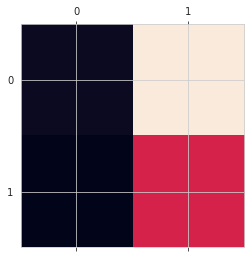

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.47405258))
print(classification_report(y_test, pred_Y>0.47405258, target_names = ['No Cardiomegaly', 'Cardiomegaly']))

## **Consolidation**

0    9332
1    4667
Name: Consolidation, dtype: int64


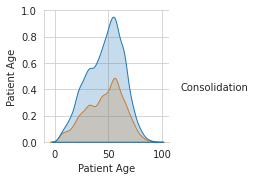

In [ ]:
positive_cases = np.sum(all_xray_df['Consolidation']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Consolidation']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Consolidation'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Consolidation']], hue='Consolidation')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Consolidation']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Consolidation']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Consolidation'].value_counts())
print('test', test_df['Consolidation'].value_counts())
raw_train_df.sample(1)

train 9799 validation 2520 test 1680
train 0    6532
1    3267
Name: Consolidation, dtype: int64
test 0    1120
1     560
Name: Consolidation, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
1573,00011966_018.png,Infiltration,18,11966,22,M,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/Images/image6/00011966_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
train_df = raw_train_df.groupby(['Consolidation']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 9799


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Consolidation',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 13999 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.5424 - binary_accuracy: 0.6002 - mae: 0.4082 
Epoch 00001: val_loss improved from inf to 0.69129, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 361s 36s/step - loss: 1.5424 - binary_accuracy: 0.6002 - mae: 0.4082 - val_loss: 0.6913 - val_binary_accuracy: 0.6775 - val_mae: 0.4991
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8411 - binary_accuracy: 0.5964 - mae: 0.4336 
Epoch 00002: val_loss improved from 0.69129 to 0.68071, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 357s 36s/step - loss: 0.8411 - binary_accuracy: 0.5964 - mae: 0.4336 - val_loss: 0.6807 - val_binary_accuracy: 0.6775 - val_mae: 0.4934
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7266 - binary_accuracy: 0.6224 - mae: 0.4288 
Epoch 00003: val_loss improved from 0.68071 to 0.66024, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 24s 349ms/step


In [ ]:
pred_Y

array([[0.46614152],
       [0.46614152],
       [0.46614152],
       ...,
       [0.46614152],
       [0.46614152],
       [0.46614152]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.46614152], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.677539587020874


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

No Consolidation       0.68      1.00      0.81      1454
   Consolidation       0.00      0.00      0.00       692

        accuracy                           0.68      2146
       macro avg       0.34      0.50      0.40      2146
    weighted avg       0.46      0.68      0.55      2146



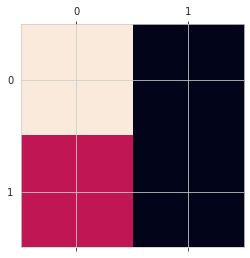

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.46614152))
print(classification_report(y_test, pred_Y>0.46614152, target_names = ['No Consolidation', 'Consolidation']))

## **Edema**

0    4604
1    2303
Name: Edema, dtype: int64


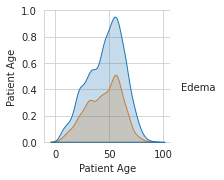

In [ ]:
positive_cases = np.sum(all_xray_df['Edema']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Edema']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Edema'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Edema']], hue='Edema')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Edema']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Edema']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Edema'].value_counts())
print('test', test_df['Edema'].value_counts())
raw_train_df.sample(1)

train 4834 validation 1243 test 830
train 0    3222
1    1612
Name: Edema, dtype: int64
test 0    553
1    277
Name: Edema, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
5765,00014058_002.png,Edema,12,14058,55,M,PA,1940,2021,0.194311,0.194311,/content/drive/MyDrive/Images/image7/00014058_...,False,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
train_df = raw_train_df.groupby(['Edema']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 4834


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Edema',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 6907 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.6385 - binary_accuracy: 0.5838 - mae: 0.4182 
Epoch 00001: val_loss improved from inf to 0.71625, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 347s 34s/step - loss: 1.6385 - binary_accuracy: 0.5838 - mae: 0.4182 - val_loss: 0.7163 - val_binary_accuracy: 0.3314 - val_mae: 0.5106
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8681 - binary_accuracy: 0.6293 - mae: 0.3876 
Epoch 00002: val_loss improved from 0.71625 to 0.71472, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 353s 35s/step - loss: 0.8681 - binary_accuracy: 0.6293 - mae: 0.3876 - val_loss: 0.7147 - val_binary_accuracy: 0.3314 - val_mae: 0.5099
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7198 - binary_accuracy: 0.6477 - mae: 0.3774 
Epoch 00003: val_loss did not improve from 0.71472
10/10 [==============================] - 354s 36s

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

65/65 [==============================] - 23s 348ms/step


In [ ]:
pred_Y

array([[0.6823489 ],
       [0.6823489 ],
       [0.6823489 ],
       ...,
       [0.6823489 ],
       [0.6823489 ],
       [0.68234897]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.6823489], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.3314037621021271


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.49651852271939606


              precision    recall  f1-score   support

    No Edema       0.67      0.96      0.79      1386
       Edema       0.29      0.03      0.05       687

    accuracy                           0.65      2073
   macro avg       0.48      0.50      0.42      2073
weighted avg       0.54      0.65      0.54      2073



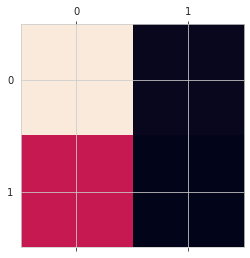

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.6823489))
print(classification_report(y_test, pred_Y>0.6823489, target_names = ['No Edema', ' Edema']))

## **Effusion**

0    26632
1    13317
Name: Effusion, dtype: int64


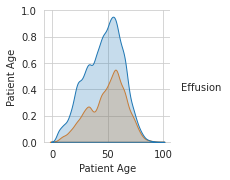

In [ ]:
positive_cases = np.sum(all_xray_df['Effusion']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Effusion']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Effusion'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Effusion']], hue='Effusion')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Effusion']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Effusion']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Effusion'].value_counts())
print('test', test_df['Effusion'].value_counts())
raw_train_df.sample(1)

train 27964 validation 7191 test 4794
train 0    18642
1     9322
Name: Effusion, dtype: int64
test 0    3196
1    1598
Name: Effusion, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
39619,00000116_034.png,Cardiomegaly|Effusion|Pleural_Thickening,34,116,74,F,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/Images/image1/00000116_...,False,0.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
train_df = raw_train_df.groupby(['Effusion']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 27964


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Effusion',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 39949 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.6379 - binary_accuracy: 0.5882 - mae: 0.4151 
Epoch 00001: val_loss improved from inf to 0.68022, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 433s 43s/step - loss: 1.6379 - binary_accuracy: 0.5882 - mae: 0.4151 - val_loss: 0.6802 - val_binary_accuracy: 0.6771 - val_mae: 0.4932
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9632 - binary_accuracy: 0.5712 - mae: 0.4456 
Epoch 00002: val_loss improved from 0.68022 to 0.66556, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 356s 36s/step - loss: 0.9632 - binary_accuracy: 0.5712 - mae: 0.4456 - val_loss: 0.6656 - val_binary_accuracy: 0.6771 - val_mae: 0.4843
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8080 - binary_accuracy: 0.6346 - mae: 0.4412 
Epoch 00003: val_loss did not improve from 0.66556
10/10 [==============================] - 362s 36s

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 39s 558ms/step


In [ ]:
pred_Y

array([[0.44098994],
       [0.44098994],
       [0.44098994],
       ...,
       [0.44098994],
       [0.44098994],
       [0.44098994]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.44098994], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.67707359790802


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5


              precision    recall  f1-score   support

 No Effusion       0.68      1.00      0.81      1453
    Effusion       0.00      0.00      0.00       693

    accuracy                           0.68      2146
   macro avg       0.34      0.50      0.40      2146
weighted avg       0.46      0.68      0.55      2146



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


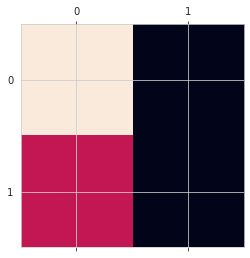

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.44098994))
print(classification_report(y_test, pred_Y>0.44098994, target_names = ['No Effusion', ' Effusion']))

## **Emphysema**

0    5032
1    2516
Name: Emphysema, dtype: int64


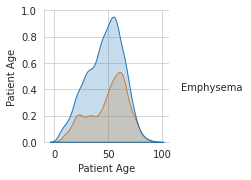

In [ ]:
positive_cases = np.sum(all_xray_df['Emphysema']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Emphysema']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Emphysema'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Emphysema']], hue='Emphysema')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Emphysema']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Emphysema']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Emphysema'].value_counts())
print('test', test_df['Emphysema'].value_counts())
raw_train_df.sample(1)

train 5283 validation 1359 test 906
train 0    3522
1    1761
Name: Emphysema, dtype: int64
test 0    604
1    302
Name: Emphysema, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
5993,00015685_004.png,Emphysema|Mass,4,15685,75,F,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/Images/image7/00015685_...,False,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
train_df = raw_train_df.groupby(['Emphysema']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 5283


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Emphysema',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 7548 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.9042 - binary_accuracy: 0.5616 - mae: 0.4454 
Epoch 00001: val_loss improved from inf to 0.67694, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 364s 35s/step - loss: 1.9042 - binary_accuracy: 0.5616 - mae: 0.4454 - val_loss: 0.6769 - val_binary_accuracy: 0.6612 - val_mae: 0.4912
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9804 - binary_accuracy: 0.5616 - mae: 0.4502 
Epoch 00002: val_loss improved from 0.67694 to 0.66422, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 353s 36s/step - loss: 0.9804 - binary_accuracy: 0.5616 - mae: 0.4502 - val_loss: 0.6642 - val_binary_accuracy: 0.6612 - val_mae: 0.4827
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7879 - binary_accuracy: 0.5960 - mae: 0.4458 
Epoch 00003: val_loss did not improve from 0.66422
10/10 [==============================] - 347s 35s

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

In [ ]:
pred_Y

array([[0.39485064],
       [0.39485064],
       [0.39485064],
       ...,
       [0.39485064],
       [0.39485064],
       [0.3948506 ]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.3948506], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.661230206489563


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5025683080767691


              precision    recall  f1-score   support

No Emphysema       0.76      0.01      0.03      1419
   Emphysema       0.34      0.99      0.51       727

    accuracy                           0.34      2146
   macro avg       0.55      0.50      0.27      2146
weighted avg       0.62      0.34      0.19      2146



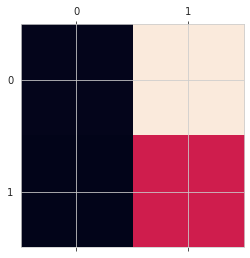

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.3948506))
print(classification_report(y_test, pred_Y>0.3948506, target_names = ['No Emphysema', 'Emphysema']))

## **Fibrosis**

0    3372
1    1686
Name: Fibrosis, dtype: int64


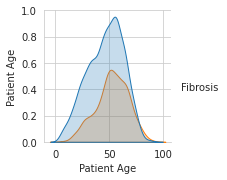

In [ ]:
positive_cases = np.sum(all_xray_df['Fibrosis']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Fibrosis']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Fibrosis'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Fibrosis']], hue='Fibrosis')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Fibrosis']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Fibrosis']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Fibrosis'].value_counts())
print('test', test_df['Fibrosis'].value_counts())
raw_train_df.sample(1)

train 3540 validation 910 test 608
train 0    2360
1    1180
Name: Fibrosis, dtype: int64
test 0    405
1    203
Name: Fibrosis, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
155,00011235_007.png,No Finding,7,11235,68,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Images/image5/00011235_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Fibrosis']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 3540


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Fibrosis',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 5058 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.5327 - binary_accuracy: 0.5876 - mae: 0.4233 
Epoch 00001: val_loss improved from inf to 0.68647, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 255s 25s/step - loss: 1.5327 - binary_accuracy: 0.5876 - mae: 0.4233 - val_loss: 0.6865 - val_binary_accuracy: 0.6647 - val_mae: 0.4966
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.8812 - binary_accuracy: 0.5669 - mae: 0.4510 
Epoch 00002: val_loss improved from 0.68647 to 0.67818, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 252s 25s/step - loss: 0.8812 - binary_accuracy: 0.5669 - mae: 0.4510 - val_loss: 0.6782 - val_binary_accuracy: 0.6647 - val_mae: 0.4919
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7640 - binary_accuracy: 0.6178 - mae: 0.4233 
Epoch 00003: val_loss improved from 0.67818 to 0.65392, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

48/48 [==============================] - 17s 354ms/step


In [ ]:
pred_Y

array([[0.41980416],
       [0.41980416],
       [0.41980416],
       ...,
       [0.41980416],
       [0.4198042 ],
       [0.4198042 ]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.41980416], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.664690375328064


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5002677279728028


              precision    recall  f1-score   support

 No Fibrosis       0.66      0.95      0.78      1009
    Fibrosis       0.34      0.05      0.09       509

    accuracy                           0.65      1518
   macro avg       0.50      0.50      0.44      1518
weighted avg       0.56      0.65      0.55      1518



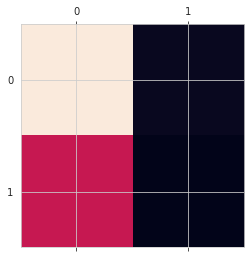

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.41980416))
print(classification_report(y_test, pred_Y>0.41980416, target_names = ['No Fibrosis', 'Fibrosis']))

## **Hernia**

0    452
1    227
Name: Hernia, dtype: int64


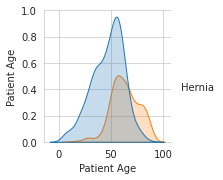

In [ ]:
positive_cases = np.sum(all_xray_df['Hernia']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Hernia']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Hernia'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Hernia']], hue='Hernia')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Hernia']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Hernia']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Hernia'].value_counts())
print('test', test_df['Hernia'].value_counts())
raw_train_df.sample(1)

train 475 validation 122 test 82
train 0    316
1    159
Name: Hernia, dtype: int64
test 0    55
1    27
Name: Hernia, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
175,00021552_016.png,Atelectasis|Infiltration|Mass|Pleural_Thickening,3,21552,50,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Images/image10/00021552...,False,1.0,0,0,0,0,0,0,1,1,1,0,0,1,0,0


In [ ]:
train_df = raw_train_df.groupby(['Hernia']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 475


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Hernia',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 679 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.8058 - binary_accuracy: 0.5642 - mae: 0.4297
Epoch 00001: val_loss improved from inf to 0.67619, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 36s 3s/step - loss: 1.8058 - binary_accuracy: 0.5642 - mae: 0.4297 - val_loss: 0.6762 - val_binary_accuracy: 0.6225 - val_mae: 0.4898
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.2628 - binary_accuracy: 0.5895 - mae: 0.4205
Epoch 00002: val_loss improved from 0.67619 to 0.67051, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 33s 3s/step - loss: 1.2628 - binary_accuracy: 0.5895 - mae: 0.4205 - val_loss: 0.6705 - val_binary_accuracy: 0.6225 - val_mae: 0.4850
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8692 - binary_accuracy: 0.6568 - mae: 0.3849
Epoch 00003: val_loss improved from 0.67051 to 0.66586, saving model to xray_class_weights.best.hdf5
10/10 

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

7/7 [==============================] - 3s 304ms/step


In [ ]:
pred_Y

array([[0.22558135],
       [0.22558132],
       [0.22558135],
       [0.22558132],
       [0.22558135],
       [0.22558135],
       [0.22558132],
       [0.22558135],
       [0.22558132],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558132],
       [0.22558135],
       [0.22558135],
       [0.22558132],
       [0.22558135],
       [0.22558132],
       [0.22558132],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558132],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558132],
       [0.22558132],
       [0.22558135],
       [0.22558135],
       [0.22558132],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.22558135],
       [0.225

In [ ]:
min(pred_Y)

array([0.22558132], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6225489974021912


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5274056652009408


              precision    recall  f1-score   support

   No Hernia       0.67      0.28      0.39       127
      Hernia       0.39      0.78      0.52        77

    accuracy                           0.47       204
   macro avg       0.53      0.53      0.46       204
weighted avg       0.57      0.47      0.44       204



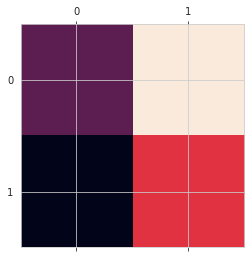

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.22558132))
print(classification_report(y_test, pred_Y>0.22558132, target_names = ['No Hernia', 'Hernia']))

## **Infiltration**

0    39788
1    19894
Name: Infiltration, dtype: int64


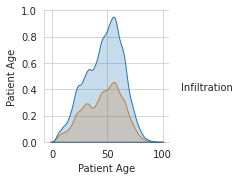

In [ ]:
positive_cases = np.sum(all_xray_df['Infiltration']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Infiltration']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Infiltration'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Infiltration']], hue='Infiltration')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Infiltration']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Infiltration']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Infiltration'].value_counts())
print('test', test_df['Infiltration'].value_counts())
raw_train_df.sample(1)

train 41777 validation 10743 test 7162
train 0    27851
1    13926
Name: Infiltration, dtype: int64
test 0    4775
1    2387
Name: Infiltration, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
34171,00005520_000.png,No Finding,0,5520,42,M,PA,2048,2500,0.168,0.168,/content/drive/MyDrive/Images/image3/00005520_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Infiltration']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 41777


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Infiltration',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 59682 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.5074 - binary_accuracy: 0.5506 - mae: 0.4518 
Epoch 00001: val_loss improved from inf to 0.70003, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 364s 36s/step - loss: 1.5074 - binary_accuracy: 0.5506 - mae: 0.4518 - val_loss: 0.7000 - val_binary_accuracy: 0.3341 - val_mae: 0.5033
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9123 - binary_accuracy: 0.5714 - mae: 0.4425 
Epoch 00002: val_loss improved from 0.70003 to 0.69451, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 362s 36s/step - loss: 0.9123 - binary_accuracy: 0.5714 - mae: 0.4425 - val_loss: 0.6945 - val_binary_accuracy: 0.3341 - val_mae: 0.5007
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7868 - binary_accuracy: 0.6130 - mae: 0.4320 
Epoch 00003: val_loss improved from 0.69451 to 0.67846, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 24s 351ms/step


In [ ]:
pred_Y

array([[0.26998577],
       [0.2699858 ],
       [0.2699858 ],
       ...,
       [0.2699858 ],
       [0.2699858 ],
       [0.2699858 ]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.26998577], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6658900380134583


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.4914375757007905


                 precision    recall  f1-score   support

No Infiltration       0.66      0.69      0.67      1429
   Infiltration       0.32      0.29      0.31       717

       accuracy                           0.56      2146
      macro avg       0.49      0.49      0.49      2146
   weighted avg       0.55      0.56      0.55      2146



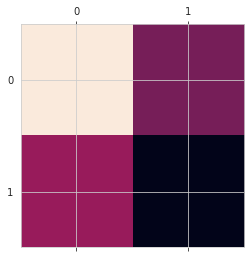

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.26998577))
print(classification_report(y_test, pred_Y>0.26998577, target_names = ['No Infiltration', 'Infiltration']))

## **Mass**

0    11564
1     5782
Name: Mass, dtype: int64


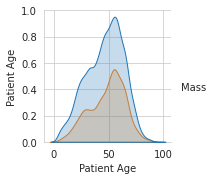

In [ ]:
positive_cases = np.sum(all_xray_df['Mass']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Mass']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Mass'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Mass']], hue='Mass')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Mass']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Mass']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Mass'].value_counts())
print('test', test_df['Mass'].value_counts())
raw_train_df.sample(1)

train 12142 validation 3122 test 2082
train 0    8095
1    4047
Name: Mass, dtype: int64
test 0    1388
1     694
Name: Mass, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
4356,00000768_000.png,No Finding,0,768,54,M,PA,2596,2901,0.143,0.143,/content/drive/MyDrive/Images/image1/00000768_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Mass']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 12142


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Mass',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 17346 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.4854 - binary_accuracy: 0.5684 - mae: 0.4299 
Epoch 00001: val_loss improved from inf to 0.69572, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 371s 36s/step - loss: 2.4854 - binary_accuracy: 0.5684 - mae: 0.4299 - val_loss: 0.6957 - val_binary_accuracy: 0.3458 - val_mae: 0.5013
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.0423 - binary_accuracy: 0.6044 - mae: 0.4485 
Epoch 00002: val_loss improved from 0.69572 to 0.67244, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 366s 37s/step - loss: 1.0423 - binary_accuracy: 0.6044 - mae: 0.4485 - val_loss: 0.6724 - val_binary_accuracy: 0.6542 - val_mae: 0.4882
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8090 - binary_accuracy: 0.6068 - mae: 0.4522 
Epoch 00003: val_loss improved from 0.67244 to 0.65440, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 26s 381ms/step


In [ ]:
pred_Y

array([[0.43382284],
       [0.43382284],
       [0.43382284],
       ...,
       [0.43382284],
       [0.43382284],
       [0.43382284]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.43382284], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6542404294013977


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.5


              precision    recall  f1-score   support

     No Mass       0.65      1.00      0.79      1404
        Mass       0.00      0.00      0.00       742

    accuracy                           0.65      2146
   macro avg       0.33      0.50      0.40      2146
weighted avg       0.43      0.65      0.52      2146



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


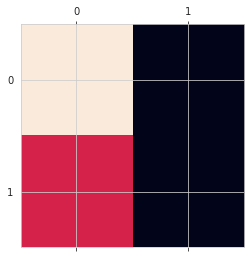

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.43382284))
print(classification_report(y_test, pred_Y>0.43382284, target_names = ['No Mass', 'Mass']))

## **Nodule**

0    12660
1     6331
Name: Nodule, dtype: int64


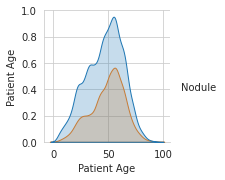

In [ ]:
positive_cases = np.sum(all_xray_df['Nodule']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Nodule']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Nodule'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Nodule']], hue='Nodule')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Nodule']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Nodule']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Nodule'].value_counts())
print('test', test_df['Nodule'].value_counts())
raw_train_df.sample(1)

train 13293 validation 3418 test 2280
train 0    8862
1    4431
Name: Nodule, dtype: int64
test 0    1520
1     760
Name: Nodule, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
11010,00012585_000.png,No Finding,0,12585,53,M,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Images/image6/00012585_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Nodule']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 13293


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Nodule',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 18991 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.8140 - binary_accuracy: 0.5622 - mae: 0.4420 
Epoch 00001: val_loss improved from inf to 0.67774, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 366s 36s/step - loss: 1.8140 - binary_accuracy: 0.5622 - mae: 0.4420 - val_loss: 0.6777 - val_binary_accuracy: 0.6803 - val_mae: 0.4918
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9721 - binary_accuracy: 0.5532 - mae: 0.4543 
Epoch 00002: val_loss improved from 0.67774 to 0.66533, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 349s 35s/step - loss: 0.9721 - binary_accuracy: 0.5532 - mae: 0.4543 - val_loss: 0.6653 - val_binary_accuracy: 0.6803 - val_mae: 0.4842
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7882 - binary_accuracy: 0.5820 - mae: 0.4529 
Epoch 00003: val_loss improved from 0.66533 to 0.65127, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 24s 347ms/step


In [ ]:
pred_Y

array([[0.4144735 ],
       [0.4144735 ],
       [0.4144735 ],
       ...,
       [0.41447347],
       [0.41447347],
       [0.41447347]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.41447347], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.680335521697998


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.4983655497424019


              precision    recall  f1-score   support

   No Nodule       0.67      0.06      0.11      1460
      Nodule       0.32      0.93      0.48       686

    accuracy                           0.34      2146
   macro avg       0.49      0.50      0.29      2146
weighted avg       0.56      0.34      0.23      2146



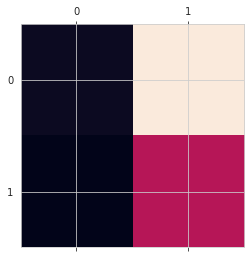

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.41447347))
print(classification_report(y_test, pred_Y>0.41447347, target_names = ['No Nodule', 'Nodule']))

## **Pleural-Thickening**

0    6768
1    3385
Name: Pleural_Thickening, dtype: int64


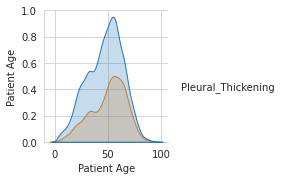

In [ ]:
positive_cases = np.sum(all_xray_df['Pleural_Thickening']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Pleural_Thickening']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Pleural_Thickening'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Pleural_Thickening']], hue='Pleural_Thickening')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Pleural_Thickening']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Pleural_Thickening']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Pleural_Thickening'].value_counts())
print('test', test_df['Pleural_Thickening'].value_counts())
raw_train_df.sample(1)

train 7107 validation 1827 test 1219
train 0    4738
1    2369
Name: Pleural_Thickening, dtype: int64
test 0    812
1    407
Name: Pleural_Thickening, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
4290,00002457_011.png,No Finding,11,2457,15,M,AP,2500,2048,0.168,0.168,/content/drive/MyDrive/Images/image2/00002457_...,False,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Pleural_Thickening']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 7107


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Pleural_Thickening',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 10153 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.7333 - binary_accuracy: 0.5766 - mae: 0.4210 
Epoch 00001: val_loss improved from inf to 0.68730, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 363s 36s/step - loss: 1.7333 - binary_accuracy: 0.5766 - mae: 0.4210 - val_loss: 0.6873 - val_binary_accuracy: 0.6598 - val_mae: 0.4970
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9121 - binary_accuracy: 0.5632 - mae: 0.4543 
Epoch 00002: val_loss did not improve from 0.68730
10/10 [==============================] - 359s 36s/step - loss: 0.9121 - binary_accuracy: 0.5632 - mae: 0.4543 - val_loss: 0.6916 - val_binary_accuracy: 0.6598 - val_mae: 0.4992
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7786 - binary_accuracy: 0.6012 - mae: 0.4418 
Epoch 00003: val_loss improved from 0.68730 to 0.68046, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 354s 36s

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 26s 373ms/step


In [ ]:
pred_Y

array([[0.33905536],
       [0.33905536],
       [0.33905536],
       ...,
       [0.3390553 ],
       [0.33905536],
       [0.3390553 ]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.3390553], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.659832239151001


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.49791521554059287


                       precision    recall  f1-score   support

No Pleural_Thickening       0.60      0.02      0.04      1416
   Pleural_Thickening       0.34      0.98      0.50       730

             accuracy                           0.34      2146
            macro avg       0.47      0.50      0.27      2146
         weighted avg       0.51      0.34      0.20      2146



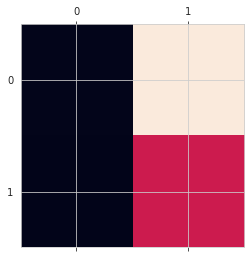

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.3390553))
print(classification_report(y_test, pred_Y>0.3390553, target_names = ['No Pleural_Thickening', 'Pleural_Thickening']))

## **Pneumonia**

False    2860
True     1431
Name: Pneumonia, dtype: int64


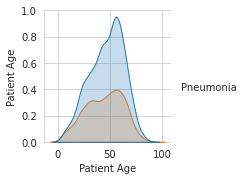

In [ ]:
positive_cases = np.sum(all_xray_df['Pneumonia']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Pneumonia']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Pneumonia'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Pneumonia']], hue='Pneumonia')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Pneumonia']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Pneumonia']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Pneumonia'].value_counts())
print('test', test_df['Pneumonia'].value_counts())
raw_train_df.sample(1)

train 3003 validation 772 test 516
train False    2002
True     1001
Name: Pneumonia, dtype: int64
test False    344
True     172
Name: Pneumonia, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
1977,00016743_011.png,No Finding,11,16743,57,F,PA,2992,2991,0.143,0.143,/content/drive/MyDrive/Images/image8/00016743_...,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = raw_train_df.groupby(['Pneumonia']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 3003


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Pneumonia',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 4291 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.0271 - binary_accuracy: 0.5255 - mae: 0.4634 
Epoch 00001: val_loss improved from inf to 0.67556, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 240s 23s/step - loss: 2.0271 - binary_accuracy: 0.5255 - mae: 0.4634 - val_loss: 0.6756 - val_binary_accuracy: 0.6739 - val_mae: 0.4905
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.0434 - binary_accuracy: 0.5638 - mae: 0.4413 
Epoch 00002: val_loss improved from 0.67556 to 0.66224, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 233s 24s/step - loss: 1.0434 - binary_accuracy: 0.5638 - mae: 0.4413 - val_loss: 0.6622 - val_binary_accuracy: 0.6739 - val_mae: 0.4819
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.8377 - binary_accuracy: 0.5774 - mae: 0.4494 
Epoch 00003: val_loss improved from 0.66224 to 0.65697, saving model to xray_class_weights.best.hdf5

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

41/41 [==============================] - 16s 363ms/step


In [ ]:
pred_Y

array([[0.31471843],
       [0.31471843],
       [0.31471843],
       ...,
       [0.31471843],
       [0.31471837],
       [0.31471837]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.31471837], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.6739130616188049


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.4977726574500768


              precision    recall  f1-score   support

No Pneumonia       0.66      0.06      0.11       868
   Pneumonia       0.33      0.93      0.48       420

    accuracy                           0.35      1288
   macro avg       0.49      0.50      0.30      1288
weighted avg       0.55      0.35      0.23      1288



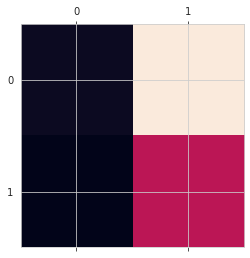

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.31471837))
print(classification_report(y_test, pred_Y>0.31471837, target_names = ['No Pneumonia', 'Pneumonia']))

## **Pneumothorax**

0    10604
1     5302
Name: Pneumothorax, dtype: int64


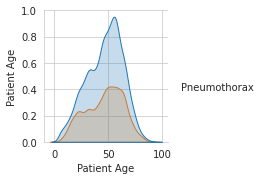

In [ ]:
positive_cases = np.sum(all_xray_df['Pneumothorax']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Pneumothorax']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Pneumothorax'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Pneumothorax']], hue='Pneumothorax')

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Pneumothorax']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Pneumothorax']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Pneumothorax'].value_counts())
print('test', test_df['Pneumothorax'].value_counts())
raw_train_df.sample(1)

train 11134 validation 2863 test 1909
train 0    7423
1    3711
Name: Pneumothorax, dtype: int64
test 0    1273
1     636
Name: Pneumothorax, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia,Patient Male,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Nothing
12760,00005539_007.png,Pneumothorax,2,5539,48,F,PA,2838,2985,0.143,0.143,/content/drive/MyDrive/Images/image3/00005539_...,False,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_df = raw_train_df.groupby(['Pneumothorax']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 11134


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(zoom_range=0.2,
                           fill_mode='nearest',
                           rotation_range=25,  
                           width_shift_range=0.25,  
                           height_shift_range=0.25,  
                           vertical_flip=False, 
                           horizontal_flip=True,
                           shear_range = 0.2,
                           samplewise_center=False, 
                           samplewise_std_normalization=False)


In [ ]:
SEED= 10
IMG_SIZE = (128, 128) 
####
def flow_from_dataframe(imgDatGen, df, batch_size, seed, img_size):
    #gc.collect()
    gen_img = imgDatGen.flow_from_dataframe(dataframe=more_balanced_df,
        x_col='path', y_col='Pneumothorax',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='grayscale',
        drop_duplicates=False)

    
        
    while True:
        X1i = gen_img.next()
        #X2i = gen_img.next()
        #gc.collect()
        yield [X1i[0], X1i[1]]

In [ ]:
flow = flow_from_dataframe(idg, more_balanced_df, 7151, SEED, IMG_SIZE)

In [ ]:
t,y= next(flow)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 15906 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t,y, 
                                   test_size = 0.30, 
                                   random_state = 2018)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  X_train.shape[1:], 
                                 include_top = False, weights = None)
mobilenet_GAP_model = Sequential()
mobilenet_GAP_model.add(mobilenet_model)
mobilenet_GAP_model.add(GlobalAveragePooling2D())
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(512))
mobilenet_GAP_model.add(Dropout(0.5))
mobilenet_GAP_model.add(Dense(1, activation = 'sigmoid'))
mobilenet_GAP_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobilenet_GAP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
history_mobilenet_GAP = mobilenet_GAP_model.fit(X_train,y_train,
                                  steps_per_epoch=10,
                                  validation_data = (X_test, y_test), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.6290 - binary_accuracy: 0.5996 - mae: 0.4074 
Epoch 00001: val_loss improved from inf to 0.68735, saving model to xray_class_weights.best.hdf5
10/10 [==============================] - 370s 37s/step - loss: 1.6290 - binary_accuracy: 0.5996 - mae: 0.4074 - val_loss: 0.6874 - val_binary_accuracy: 0.6738 - val_mae: 0.4970
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9128 - binary_accuracy: 0.5838 - mae: 0.4300 
Epoch 00002: val_loss did not improve from 0.68735
10/10 [==============================] - 369s 37s/step - loss: 0.9128 - binary_accuracy: 0.5838 - mae: 0.4300 - val_loss: 0.7084 - val_binary_accuracy: 0.3262 - val_mae: 0.5072
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7613 - binary_accuracy: 0.6014 - mae: 0.4293 
Epoch 00003: val_loss did not improve from 0.68735
10/10 [==============================] - 362s 36s/step - loss: 0.7613 - binary_accuracy: 0.6014 - m

In [ ]:
pred_Y = mobilenet_GAP_model.predict(X_test, 
                          batch_size = 32, 
                          verbose = True)

68/68 [==============================] - 25s 354ms/step


In [ ]:
pred_Y

array([[0.50759625],
       [0.50759625],
       [0.50759625],
       ...,
       [0.50759625],
       [0.50759625],
       [0.50759625]], dtype=float32)

In [ ]:
min(pred_Y)

array([0.50759625], dtype=float32)

In [ ]:
print('test accuracy = ',mobilenet_GAP_model.evaluate(X_test,y_test, verbose=0)[1])

test accuracy =  0.32618826627731323


In [ ]:
from sklearn.metrics import roc_auc_score
print('roc score = ',roc_auc_score(y_test.astype(int), pred_Y))

roc score =  0.501519462556807


                 precision    recall  f1-score   support

No Pneumothorax       0.67      0.99      0.80      1446
   Pneumothorax       0.43      0.01      0.02       700

       accuracy                           0.67      2146
      macro avg       0.55      0.50      0.41      2146
   weighted avg       0.59      0.67      0.55      2146



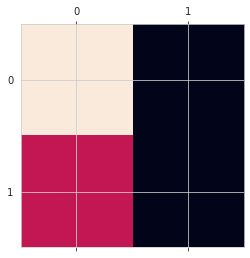

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(y_test, pred_Y>0.50759625))
print(classification_report(y_test, pred_Y>0.50759625, target_names = ['No Pneumothorax', 'Pneumothorax']))